In [2]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

In [210]:
df=pd.read_table('all_rvs.csv',delimiter=',')
list(df.columns)

['Unnamed: 0',
 'Unnamed: 0_x',
 'kepid',
 'Mass_berger',
 'KIC',
 'Kp',
 'Q',
 'Teff_santos',
 'E_Teff',
 'e_Teff',
 'logg_santos',
 'E_logg',
 'e_logg',
 'M',
 'E_M',
 'e_M',
 'Prot_santos',
 'E_Prot',
 'Sph',
 'E_Sph',
 'flag1',
 'DMK',
 'flag2',
 'flag3',
 'flag4',
 'flag5',
 'Unnamed: 0.1_x',
 'KID',
 'Teff',
 'loggKIC',
 'Mass',
 'Prot',
 'Prot_err',
 'Rper',
 'LPH',
 'w',
 'DC',
 'Flag',
 'designation',
 'source_id',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_primary_flag',
 'duplicated_source',
 'phot_g_mean_flux',
 'phot_g_mean_flux_error',
 'phot_g_mean_mag',
 '

In [211]:
df_temp=pd.read_pickle('Temp.pkl')
df_temp['kepid']=[int(i) for i in df_temp['kepid']]
df_temp

,teff_calc,kepid
0,3783.045568,892376
1,4294.608486,1026146
2,4028.989654,1026474
3,3878.329799,1162635
4,4052.501496,1164102
...,...,...
66143,5800.269677,12934488
66144,5164.256200,12934771
66145,6215.196325,12934955
66146,4761.024514,12935010


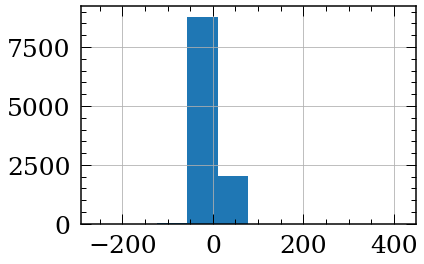

In [212]:
df=pd.merge(df,df_temp,left_on='kepid',right_on='kepid',how='inner')
df=df.loc[df['teff_calc']>3000]
df['vz'].hist()

Text(0.5, 0, 'Temperature [K]')

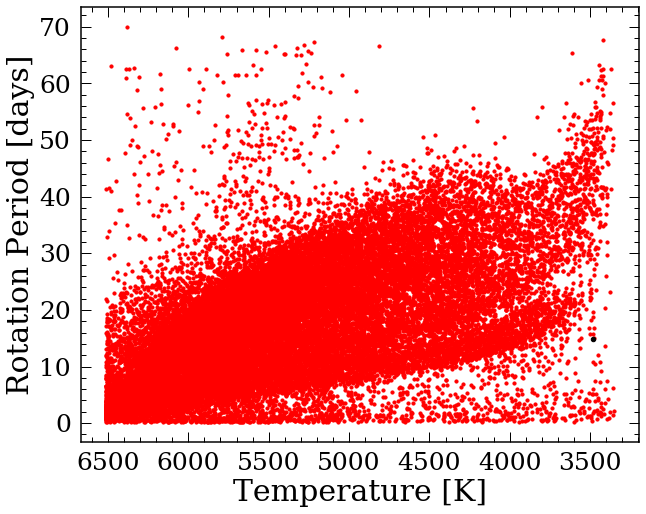

In [213]:
plt.figure(figsize=(10,8))
index_i=100
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df['teff_calc'],df['Prot'],s=10,c='r')
plt.scatter(df['teff_calc'][index_i],df['Prot'][index_i],s=20,c='k')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')
plt.xlabel('Temperature [K]')
#cb=plt.colorbar()
#cb.set_label('Verticle Velocity')

In [317]:
def Calcdv_bin(df,f1,f2,binsize_temp,binsize_rot):
    Nstars=len(df)
    
    # initialize velocity dispersion
    df['dv_MAD']=np.zeros(Nstars)
    df['dv_STD']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1]
        Prot = df.iloc[i][f2]
        
        
        mask_df1=(df[f1]>teff-binsize_temp/2) & (df[f1]<teff+binsize_temp/2)
        mask_df2=(df[f2]>Prot-binsize_rot/2) & (df[f2]<Prot+binsize_rot/2)
        totmask=mask_df1 & mask_df2

        # get the clossest stadrs v_b
        NNstars=df.loc[totmask]
    
        MAD=sum(abs(NNstars['vz']-np.median(NNstars['vz'])))/float(len(NNstars))

        df['dv_MAD'].iloc[i]=1.5*MAD
        df['dv_STD'].iloc[i]=np.std(NNstars['vz'])


def Calcdv(df,f1,f2,NN):
    Nstars=len(df)
    X_nn = StandardScaler().fit_transform(df[[f1,f2]])
    df[f1+'_norm'],df[f2+'_norm'] = X_nn[:,0], X_nn[:,1]
    
    # initialize velocity dispersion
    df['dv_MAD']=np.zeros(Nstars)
    df['dv_STD']=np.zeros(Nstars)
    for i in range(Nstars):
        update_progress(i/Nstars)
        teff = df.iloc[i][f1+'_norm']
        Prot = df.iloc[i][f2+'_norm']
        df['dist'] = np.sqrt(np.power(df[f1+'_norm']-teff,2.)+np.power(df[f2+'_norm']-Prot,2.))
        
        # get the clossest stadrs v_b
        NNstars=df.loc[df.sort_values(by=['dist']).iloc[0:NN].index]
    
        MAD=sum(abs(NNstars['vz']-np.median(NNstars['vz'])))/float(len(NNstars))

        df['dv_MAD'].iloc[i]=1.5*MAD
        df['dv_STD'].iloc[i]=np.std(NNstars['vz'])
        
def testBin(df,f1,f2,teststari,bintemp,binprot):
    Ntests=int(len(bintemp)*len(binprot))
    teff = df.iloc[teststari][f1]
    Prot = df.iloc[teststari][f2]
    #print(teff,np.power(10.,Prot))
    
    delta_vz=np.zeros(Ntests)
    temp_a=np.zeros(Ntests)
    prot_a=np.zeros(Ntests)
    stars_inc=np.zeros(Ntests)
    
    maxtemp=max(bintemp)
    maxProt=max(binprot)
    mintemp=min(bintemp)
    minProt=min(binprot)
    
    count=0
    for i in range(len(bintemp)):
        for j in range(len(binprot)):
            update_progress((count)/Ntests)
        
            mask_df1=(df[f1]>teff-bintemp[i]/2) & (df[f1]<teff+bintemp[i]/2)
            mask_df2=(df[f2]>Prot-binprot[j]/2) & (df[f2]<Prot+binprot[j]/2)
            totmask=mask_df1 & mask_df2

            # get the clossest stadrs v_b
            NNstars=df.loc[totmask]
            stars_inc[count]=len(NNstars)

            if bintemp[i]==maxtemp and binprot[j]==maxProt:
                MaxBin=NNstars
            if bintemp[i]==mintemp and binprot[j]==minProt:
                MinBin=NNstars
            mad=np.median(abs(NNstars['vz']-np.median(NNstars['vz'])))
            delta_vz[count]=mad*1.5
            #delta_vz[count]=np.std(NNstars['vz'])
            """
            if bintemp[i]==200:
                plt.figure()
                NNstars['vz'].hist()
                plt.title(str(binprot[j])+', dv='+str(np.std(NNstars['vz']))+', total star='+str(len(NNstars)))
                plt.xlim([-100,100])
                plt.ylim([0,25])
            """
            temp_a[count]=bintemp[i]
            prot_a[count]=binprot[j]
            
            count=count+1
            
    return pd.DataFrame(np.array([delta_vz,temp_a,prot_a,stars_inc]).T,columns=['vd','temp','prot','stars']),MaxBin,MinBin

def locind(temp,prot,df):
    df['dist']=np.power(df['teff_calc']-temp,2.)+np.power(df['Prot']-prot,2.)
    df=df.sort_values(by=['dist'])
    return df.index.values.astype(int)[0]

"""
bintemp=577.27
binprot=0.11
df['Prot_log']=np.log10(df['Prot'])
Calcdv_bin(df,'teff_calc','Prot_log',bintemp,binprot)
"""

"\nbintemp=577.27\nbinprot=0.11\ndf['Prot_log']=np.log10(df['Prot'])\nCalcdv_bin(df,'teff_calc','Prot_log',bintemp,binprot)\n"

In [340]:
# test bin size on particle 10
df=df.loc[df['vz']<100]
df=df.loc[df['vz']>-100]
df=df.reset_index(drop=True)
#index_i=locind(5000,15,df)
#df['Prot_log']=np.log10(df['Prot'])
index_i=9512
bintemp=[200+30*i for i in range(30)]
binprot=[0.04+0.01*i for i in range(30)]
vd_frame,MaxBin,MinBin=testBin(df,'teff_calc','Prot_log',index_i,bintemp,binprot)
delta_vz,temp_a,prot_a,starsNo=vd_frame.vd.values,vd_frame.temp.values,vd_frame.prot.values,vd_frame.stars.values

Progress: [####################] 99.9%


6.0411960862402525 217.57575757575756 0.04


"\nplt.figure(figsize=(10,8))\ncm = plt.cm.get_cmap('viridis',10)\nplt.scatter(temp_a,prot_a,c=delta_vz)\ncb=plt.colorbar()\ncb.set_label('Velocity Dispersion')\n"

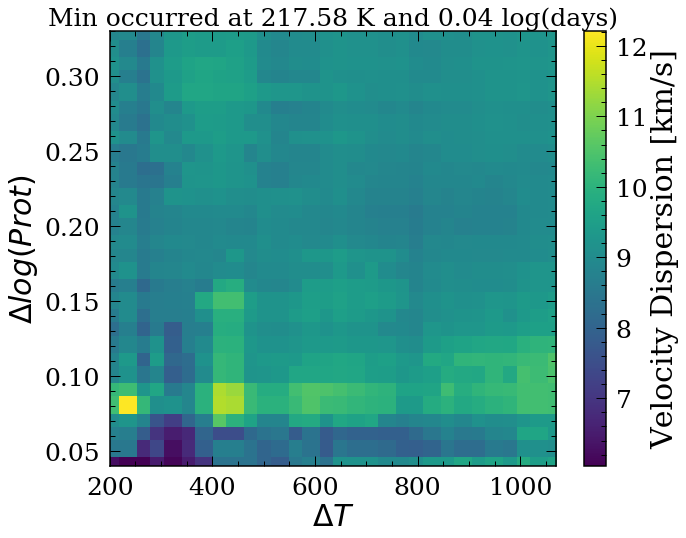

In [341]:
from scipy.interpolate import griddata
temp_g=np.linspace(min(bintemp),max(bintemp),100)
rot_g=np.linspace(min(binprot),max(binprot),100)
grid_x, grid_y = np.meshgrid(temp_g,rot_g)

points=np.zeros((len(temp_a),2))
points[:,0]=temp_a
points[:,1]=prot_a
grid_z1 = griddata(points, delta_vz, (grid_x, grid_y), method='nearest')


temp_min=0
Prot_min=0
grid_z1=grid_z1.T
oldele=grid_z1[0][0]

finali=0
finalj=0
for i in range(len(grid_z1)):
    for j in range(len(grid_z1[i])):
        if grid_z1[i,j]<oldele:
            finali=i
            finalj=j
            temp_min=temp_g[i]
            Prot_min=rot_g[j]
            oldele=grid_z1[i,j]
print(oldele,temp_min,Prot_min)


plt.figure(figsize=(10,8))
plt.imshow(grid_z1.T, extent=(min(bintemp),max(bintemp),min(binprot),max(binprot)), origin='lower', aspect='auto')
#plt.plot(temp_min,Prot_min,'ro')
plt.xlabel('$\Delta T$')
plt.ylabel('$\Delta log(Prot)$')
cb=plt.colorbar()
cb.set_label('Velocity Dispersion [km/s]')
plt.title('Min occurred at %.2f K and %.2f log(days)'%(temp_min,Prot_min),fontsize=25)
"""
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(temp_a,prot_a,c=delta_vz)
cb=plt.colorbar()
cb.set_label('Velocity Dispersion')
"""

In [342]:
average_vd_tempbin=np.zeros(len(bintemp))
average_vd_protbin=np.zeros(len(binprot))
average_vd_all_prot=np.zeros((len(binprot),len(bintemp)))
average_vd_all_temp=np.zeros((len(bintemp),len(binprot)))
for i in range(len(bintemp)):
    av=vd_frame.loc[vd_frame['temp']==bintemp[i]]
    average_vd_tempbin[i]=np.median(av['vd'])

for i in range(len(binprot)):
    av=vd_frame.loc[vd_frame['prot']==binprot[i]]
    average_vd_protbin[i]=np.median(av['vd'])    
    
for i in range(len(binprot)):
    av=vd_frame.loc[vd_frame['prot']==binprot[i]]
    average_vd_all_prot[i,:]=av['vd']
    
for i in range(len(bintemp)):
    av=vd_frame.loc[vd_frame['temp']==bintemp[i]]
    average_vd_all_temp[i,:]=av['vd']

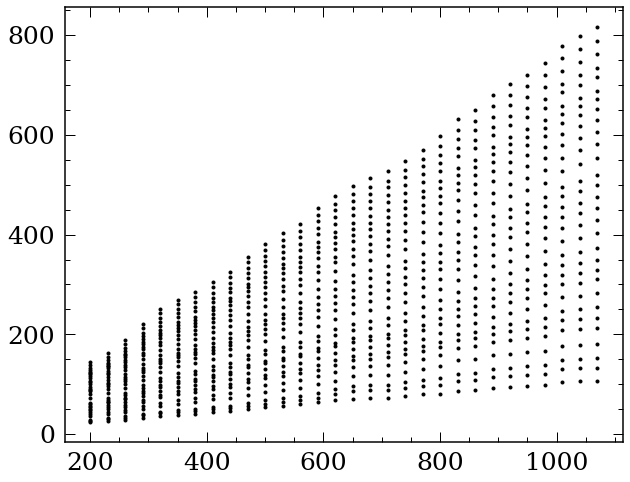

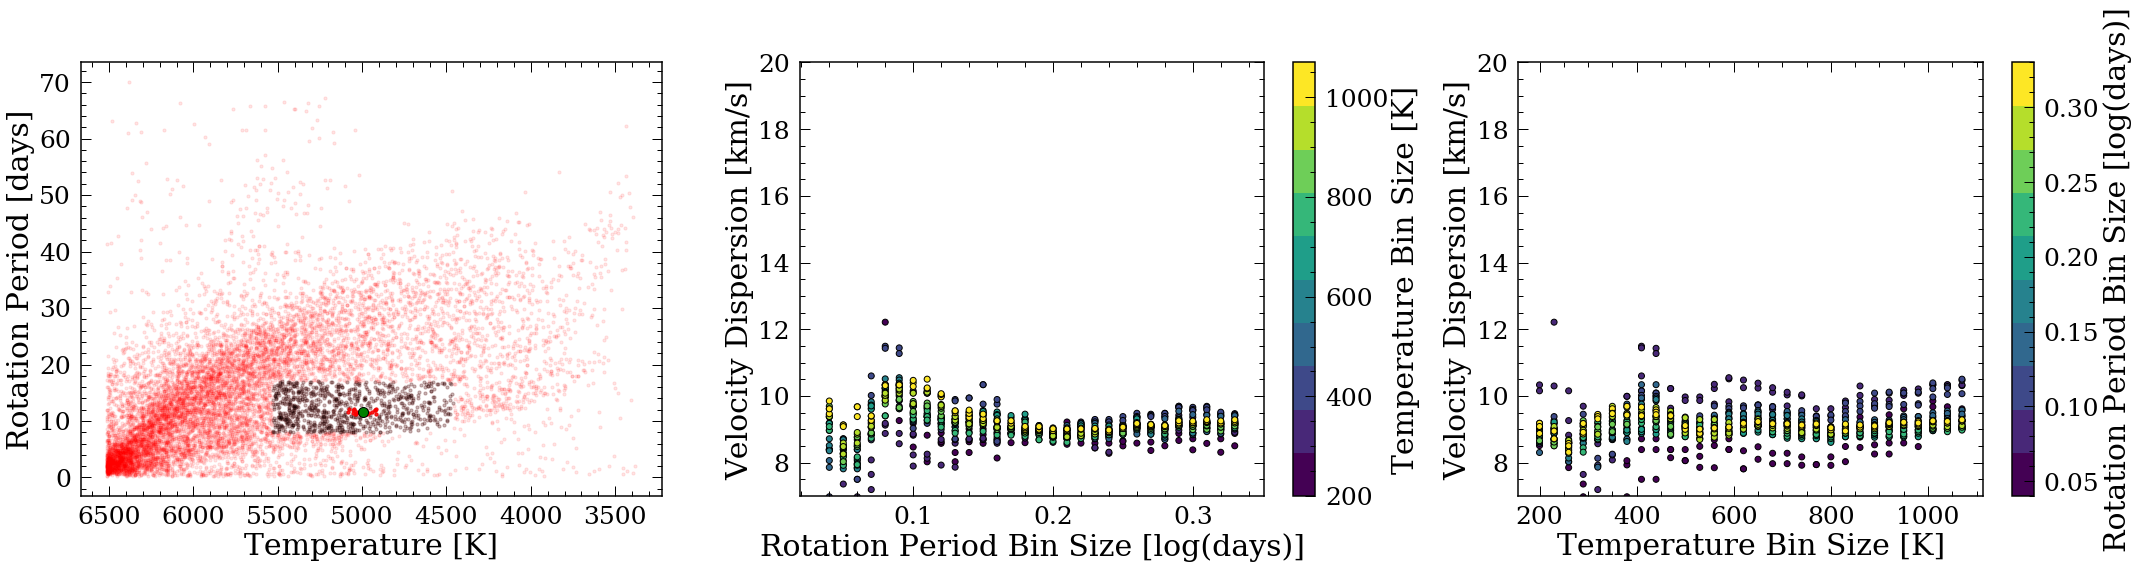

In [343]:
plt.figure(figsize=(10,8))
plt.plot(temp_a,starsNo,'k.')

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df['teff_calc'],df['Prot'],s=10,c='r',alpha=0.1)
plt.scatter(MaxBin['teff_calc'],MaxBin['Prot'],s=10,c='k',alpha=0.2)
plt.scatter(MinBin['teff_calc'],MinBin['Prot'],s=10,c='r',alpha=0.8)
plt.scatter(df.iloc[index_i]['teff_calc'],df.iloc[index_i]['Prot'],s=100,c='g',edgecolor='k')

plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')
plt.xlabel('Temperature [K]')

plt.subplot(1,3,2)
#plt.plot(binprot,average_vd_all,color='k',alpha=0.2)
plt.scatter(prot_a,delta_vz,c=temp_a,edgecolors='k',cmap=cm)
plt.ylim([7,20])
plt.xlabel('Rotation Period Bin Size [log(days)]')
plt.ylabel('Velocity Dispersion [km/s]')
cb=plt.colorbar()
cb.set_label('Temperature Bin Size [K]')

plt.subplot(1,3,3)
#plt.plot(binprot,average_vd_all,color='k',alpha=0.2)
plt.scatter(temp_a,delta_vz,c=prot_a,edgecolors='k',cmap=cm)
plt.ylim([7,20])
plt.xlabel('Temperature Bin Size [K]')
plt.ylabel('Velocity Dispersion [km/s]')
cb=plt.colorbar()
cb.set_label('Rotation Period Bin Size [log(days)]')

plt.tight_layout()

plt.savefig('Binsize_MAD_'+str(index_i)+'.png')

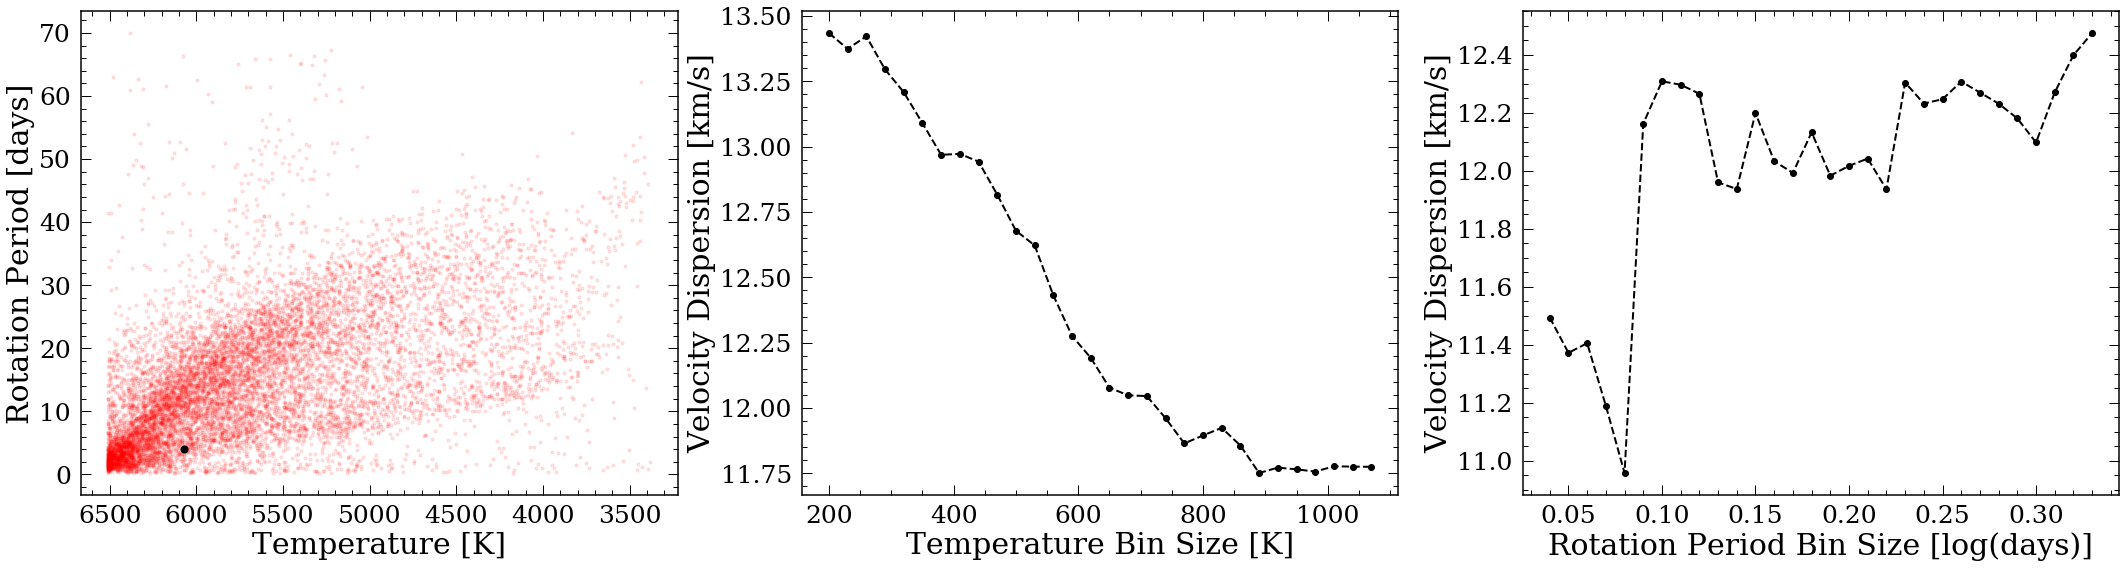

In [294]:
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.scatter(df['teff_calc'],df['Prot'],s=10,c='r',alpha=0.1)
plt.scatter(df['teff_calc'][index_i],df['Prot'][index_i],s=50,c='k')
plt.gca().invert_xaxis()
plt.ylabel('Rotation Period [days]')
plt.xlabel('Temperature [K]')
#cb=plt.colorbar()
#cb.set_label('Verticle Velocity')
plt.subplot(1,3,2)
plt.plot(bintemp,average_vd_tempbin,'k--o')
plt.xlabel('Temperature Bin Size [K]')
plt.ylabel('Velocity Dispersion [km/s]')
plt.subplot(1,3,3)
plt.plot(binprot,average_vd_protbin,'k--o')
plt.xlabel('Rotation Period Bin Size [log(days)]')
plt.ylabel('Velocity Dispersion [km/s]')
plt.tight_layout()

plt.savefig('Binsize_'+str(index_i)+'.png')
